In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.transforms import ToPILImage
import torchvision.utils as vutils

from torchcam.methods import LayerCAM, SmoothGradCAMpp
from torchcam.utils import overlay_mask

import clip

import argparse
import os
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image


from tqdm import tqdm
from itertools import cycle

from models.resnet import CustomResNet
from models.visual_transformer import ProjectionHead, VisualTransformer
from domainnet_data import DomainNetDataset, get_domainnet_loaders, get_data_from_saved_files
from utils import SimpleDINOLoss, compute_accuracy, compute_similarities, plot_grad_flow, plot_confusion_matrix
from prompts.FLM import generate_label_mapping_by_frequency, label_mapping_base


to_pil = ToPILImage()


In [2]:
def load_image(file_path):
    """
    Load an image and convert it to a NumPy array with values in the range [0, 255].

    Args:
        file_path (str): Path to the image file.

    Returns:
        np.ndarray: Image as a NumPy array with values in the range [0, 255].
    """
    # Open the image file
    image = Image.open(file_path)

    # Convert to RGB mode if not already in RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert image to NumPy array
    image_array = np.array(image)

    # Ensure values are in the range [0, 255]
    image_array = np.clip(image_array, 0, 255)

    return image_array


In [3]:

def unnormalize(tensor):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    mean_tensor = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std_tensor = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    tensor.mul_(std_tensor[:, None, None]).add_(mean_tensor[:, None, None])
    return tensor

def save_image(tensor, file_name):

    tensor = tensor.detach().cpu()
    # Ensure it's in the range [0, 1]
    tensor = torch.clamp(tensor, 0, 1)

    # Convert to image and save
    vutils.save_image(tensor, file_name)


In [4]:

# transform = transforms.Compose(
#     [transforms.Resize((224, 224)),
#     # transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                         std=[0.229, 0.224, 0.225])])

CLIP_custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

Resnet_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
])

def gaussian_noise(x, severity=1):
    c = [0., .08, .12, 0.18, 0.26, 0.38][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255




# PIL_image = CLIP_custom_transform(Image.open('./data/domainnet_v1.0/real/toothpaste/real_318_000284.jpg'))

im = load_image('./data/domainnet_v1.0/real/toothpaste/real_318_000284.jpg')
PIL_image = CLIP_custom_transform(Image.fromarray(gaussian_noise(im, severity=1).astype(np.uint8)))

# l = torch.from_numpy(np.array([317]))
# valset = torch.utils.data.TensorDataset(image, l)
# val_loader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)

In [5]:
base_dir = f"logs/classifier/resnet50_domainnet_real"
data_dir = f"data/domainnet_v1.0"
prompt_embeddings_pth = "prompts/CLIP_RN50_text_embeddings.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model, preprocess = clip.load("RN50", device=device)

print(preprocess)
clip_model.eval()

# Load class names from a text file
with open(os.path.join(data_dir, 'class_names.txt'), 'r') as f:
    class_names = [line.strip() for line in f.readlines()]
    
loaders, _ = get_domainnet_loaders("real", batch_size=10, data_dir=data_dir)

train_loader = loaders['train']
val_loader = loaders['test']

text_encodings = torch.load(prompt_embeddings_pth)[0]

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f0f86aaa8b0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)
Number of classes in real train set: 345
Number of images in real train set: 120906

Number of classes in real test set: 345
Number of images in real test set: 52041



In [6]:
# Preprocess the image for clip
image_CLIP = preprocess(PIL_image).unsqueeze(0).to(device)

# Encode the image using CLIP encoder_image
clip_image_features = clip_model.encode_image(image_CLIP)

# Compute similarities between image embeddings and text encodings
orig_similarities_ = compute_similarities(clip_image_features, text_encodings, mode="cosine")
orig_prob_ = F.softmax(orig_similarities_, dim=-1)
orig_predictions_ = torch.argmax(orig_prob_, dim=-1)


print(f"Original Zero-shot prediction: {class_names[orig_predictions_[0].item()]}")

Original Zero-shot prediction: book


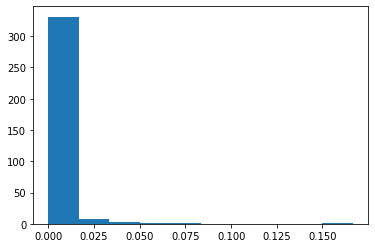

In [7]:


plt.hist(orig_prob_[0].detach().cpu().numpy(), bins=10)
plt.show()

In [8]:


# Load your trained model from checkpoint
checkpoint = torch.load('logs/classifier/resnet50_domainnet_real/best_checkpoint.pth')

resnet_model = CustomResNet(model_name='resnet50', num_classes=345)
resnet_model.load_state_dict(checkpoint['model_state_dict'])
resnet_model.eval()
print(f"Loaded model from epoch {checkpoint['epoch']}")
resnet_model.to('cuda')


projector = ProjectionHead(input_dim=2048, output_dim=1024).to('cuda')
# Load projector weights from checkpoint
projector.load_state_dict(torch.load('logs/classifier/resnet50_domainnet_real/projection_default_prompt_feat_sim0.1_distill1_DN_mapping1_scaled_logits/best_projector_weights.pth'))
projector.eval()

resnet_images = Resnet_transform(PIL_image).unsqueeze(0).to('cuda')
# Get the ResNet predictions
resnet_logits, resnet_embeddings = resnet_model(resnet_images, return_features=True)
probs_from_resnet = F.softmax(resnet_logits, dim=-1)
resnet_predictions = torch.argmax(probs_from_resnet, dim=-1)

# Project the resnet embeddings
proj_embeddings = projector(resnet_embeddings)
# Compute the predictions using the projected embeddings
similarities = compute_similarities(proj_embeddings, text_encodings, mode="DN")
probs_from_proj = F.softmax(similarities, dim=-1)
proj_predictions = torch.argmax(probs_from_proj, dim=-1)

print(f"ResNet predictions: {class_names[resnet_predictions[0].item()]}")
print(f"Projected predictions: {class_names[proj_predictions[0].item()]}")


/home/orion/.virtualenvs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/orion/.virtualenvs/pytorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded model from epoch 81
ResNet predictions: toothbrush
Projected predictions: toothbrush


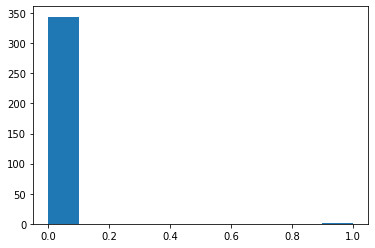

In [9]:
plt.hist(probs_from_resnet[0].detach().cpu().numpy(), bins=10)
plt.show()

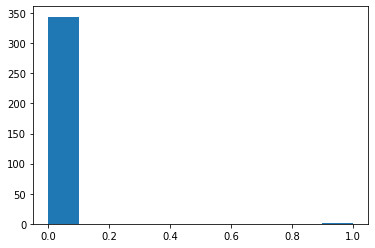

In [10]:
plt.hist(probs_from_proj[0].detach().cpu().numpy(), bins=10)
plt.show()

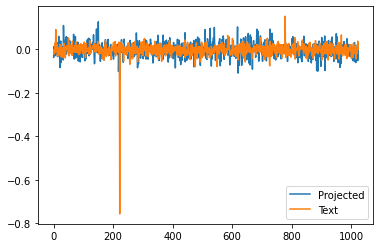

In [11]:
clip_image_features_norm = F.normalize(clip_image_features[0], dim=-1)
proj_embeddings_norm = F.normalize(proj_embeddings[0], dim=-1)

clip_text_features_norm = F.normalize(text_encodings[300], dim=-1)

# plt.plot(clip_image_features_norm.detach().cpu().numpy(), label="CLIP")
plt.plot(proj_embeddings_norm.detach().cpu().numpy(), label="Projected")
plt.plot(clip_text_features_norm.detach().cpu().numpy(), label="Text")
plt.legend()
plt.show()

In [16]:
dataset = DomainNetDataset(root_dir='data/domainnet_v1.0', domain='real', split='train', transform=None)


all_clip_embeddings = []
all_custom_clip_embeddings = []
all_resnet_embeddings = []
all_proj_embeddings = []
for i in range(len(dataset)):
    images, label = dataset[i]

    resnet_images = Resnet_transform(images).unsqueeze(0).to('cuda')
    # Get the ResNet predictions
    resnet_logits, resnet_embeddings = resnet_model(resnet_images, return_features=True)

    # Project the resnet embeddings
    proj_embeddings = projector(resnet_embeddings)
    all_proj_embeddings.append(proj_embeddings.detach().cpu())
    
    # Preprocess the image for clip
    CLIP_images = preprocess(images).unsqueeze(0).to(device)
    clip_image_features = clip_model.encode_image(CLIP_images)
    all_clip_embeddings.append(clip_image_features.detach().cpu())

    custom_CLIP_images = preprocess(CLIP_custom_transform(images)).unsqueeze(0).to(device)
    custom_clip_image_features = clip_model.encode_image(custom_CLIP_images)
    all_custom_clip_embeddings.append(custom_clip_image_features.detach().cpu())


    if i == 100:
        break

all_clip_embeddings = torch.cat(all_clip_embeddings, dim=0)
all_proj_embeddings = torch.cat(all_proj_embeddings, dim=0)
all_custom_clip_embeddings = torch.cat(all_custom_clip_embeddings, dim=0)

Number of classes in real train set: 345
Number of images in real train set: 120906



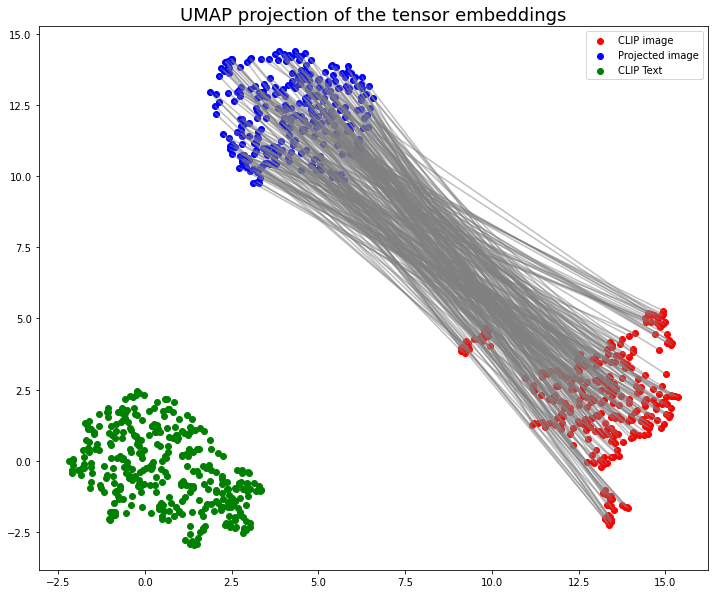

In [15]:
from utils import plot_umap_embeddings

plot_umap_embeddings(all_clip_embeddings, all_proj_embeddings, text_encodings.detach().cpu(), labels=['CLIP image', 'Projected image', 'CLIP Text'])